# Mandelbrot With Blosc2 DSL vs Blosc2+Numba

This notebook compares two Blosc2-backed execution paths for Mandelbrot side-by-side:
- `@blosc2.dsl_kernel` through `blosc2.lazyudf` (`blosc2+DSL`)
- a Numba-compiled `lazyudf` kernel (`blosc2+numba`), following the pattern in `compute_udf_numba.py`

The previous native Numba implementation is moved earlier as a baseline and is still plotted for visual comparison.


In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

import blosc2

In [2]:
# Problem size and Mandelbrot domain
WIDTH = 1200
HEIGHT = 800
MAX_ITER = 200
X_MIN, X_MAX = -2.0, 0.6
Y_MIN, Y_MAX = -1.1, 1.1
DTYPE = np.float32

x = np.linspace(X_MIN, X_MAX, WIDTH, dtype=DTYPE)
y = np.linspace(Y_MIN, Y_MAX, HEIGHT, dtype=DTYPE)
cr_np, ci_np = np.meshgrid(x, y)

# Keep compression overhead low for the timing comparison
cparams_fast = blosc2.CParams(codec=blosc2.Codec.LZ4, clevel=1)
cr_b2 = blosc2.asarray(cr_np, cparams=cparams_fast)
ci_b2 = blosc2.asarray(ci_np, cparams=cparams_fast)

print(f"grid: {cr_np.shape}, dtype: {cr_np.dtype}")

grid: (800, 1200), dtype: float32


In [3]:
@blosc2.dsl_kernel
def mandelbrot_dsl(cr, ci, max_iter):
    zr = 0.0
    zi = 0.0
    escape_iter = float(max_iter)
    for i in range(max_iter):
        if zr * zr + zi * zi > 4:
            escape_iter = i
            break
        zr_new = zr * zr - zi * zi + cr
        zi = 2 * zr * zi + ci
        zr = zr_new
    return escape_iter


if mandelbrot_dsl.dsl_source is None:
    raise RuntimeError("DSL extraction failed. Re-run this cell in a file-backed notebook session.")

print(mandelbrot_dsl.dsl_source)

def mandelbrot_dsl(cr, ci, max_iter):
    zr = 0.0
    zi = 0.0
    escape_iter = float(max_iter)
    for i in range(max_iter):
        if zr * zr + zi * zi > 4:
            escape_iter = i
            break
        zr_new = zr * zr - zi * zi + cr
        zi = 2 * zr * zi + ci
        zr = zr_new
    return escape_iter


In [4]:
@njit(parallel=True, fastmath=False)
def mandelbrot_numba_native(cr, ci, max_iter):
    h, w = cr.shape
    out = np.empty((h, w), dtype=np.float32)
    for iy in prange(h):
        for ix in range(w):
            zr = np.float32(0.0)
            zi = np.float32(0.0)
            escape_iter = np.float32(max_iter)
            c_re = cr[iy, ix]
            c_im = ci[iy, ix]
            for it in range(max_iter):
                zr2 = zr * zr
                zi2 = zi * zi
                if zr2 + zi2 > np.float32(4.0):
                    escape_iter = np.float32(it)
                    break
                zr_new = zr2 - zi2 + c_re
                zi_new = np.float32(2.0) * zr * zi + c_im
                zr = zr_new
                zi = zi_new
            out[iy, ix] = escape_iter
    return out


@njit(parallel=True, fastmath=False)
def mandelbrot_numba_lazyudf(inputs_tuple, output, offset):
    cr = inputs_tuple[0]
    ci = inputs_tuple[1]
    max_iter = np.int32(MAX_ITER)
    h, w = output.shape
    for iy in prange(h):
        for ix in range(w):
            zr = np.float32(0.0)
            zi = np.float32(0.0)
            escape_iter = np.float32(max_iter)
            c_re = cr[iy, ix]
            c_im = ci[iy, ix]
            for it in range(max_iter):
                zr2 = zr * zr
                zi2 = zi * zi
                if zr2 + zi2 > np.float32(4.0):
                    escape_iter = np.float32(it)
                    break
                zr_new = zr2 - zi2 + c_re
                zi_new = np.float32(2.0) * zr * zi + c_im
                zr = zr_new
                zi = zi_new
            output[iy, ix] = escape_iter

### How to read the timings

- **First run** includes one-time costs (JIT/compilation, loader, setup).
- **Best run** represents steady-state compute throughput after warmup.
- For DSL backends, cache state affects first-run results (`cc` and `tcc` can hit warm caches).


In [5]:
def best_time(func, repeats=3, warmup=1):
    for _ in range(warmup):
        func()
    best = float("inf")
    best_out = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = func()
        dt = time.perf_counter() - t0
        if dt < best:
            best = dt
            best_out = out
    return best, best_out


def run_numba_native():
    return mandelbrot_numba_native(cr_np, ci_np, MAX_ITER)


def run_blosc2_numba():
    lazy = blosc2.lazyudf(mandelbrot_numba_lazyudf, (cr_b2, ci_b2), dtype=np.float32, cparams=cparams_fast)
    return lazy.compute()


def run_dsl_cc():
    lazy = blosc2.lazyudf(
        mandelbrot_dsl,
        (cr_b2, ci_b2, MAX_ITER),
        dtype=np.float32,
        cparams=cparams_fast,
        jit_backend="cc",
    )
    return lazy.compute()


def run_dsl_tcc():
    lazy = blosc2.lazyudf(
        mandelbrot_dsl,
        (cr_b2, ci_b2, MAX_ITER),
        dtype=np.float32,
        cparams=cparams_fast,
        jit_backend="tcc",
    )
    return lazy.compute()


# Measure first iteration (includes one-time overhead, especially JIT compile)
t0 = time.perf_counter()
_ = run_numba_native()
t_numba_native_first = time.perf_counter() - t0

t0 = time.perf_counter()
_ = run_blosc2_numba()
t_b2_numba_first = time.perf_counter() - t0

t0 = time.perf_counter()
_ = run_dsl_cc()
t_dsl_cc_first = time.perf_counter() - t0

t0 = time.perf_counter()
_ = run_dsl_tcc()
t_dsl_tcc_first = time.perf_counter() - t0


t_numba_native, img_numba_native = best_time(run_numba_native, repeats=5, warmup=1)
t_b2_numba, img_b2_numba = best_time(run_blosc2_numba, repeats=3, warmup=1)
t_dsl_cc, img_dsl_cc = best_time(run_dsl_cc, repeats=3, warmup=1)
t_dsl_tcc, img_dsl_tcc = best_time(run_dsl_tcc, repeats=3, warmup=1)

cold_overhead_native = t_numba_native_first - t_numba_native
cold_overhead_b2_numba = t_b2_numba_first - t_b2_numba
cold_overhead_dsl_tcc = t_dsl_tcc_first - t_dsl_tcc
cold_overhead_dsl_cc = t_dsl_cc_first - t_dsl_cc

steady_speedup_b2_numba_vs_native = t_numba_native / t_b2_numba
steady_speedup_dsl_tcc_vs_native = t_numba_native / t_dsl_tcc
steady_speedup_dsl_cc_vs_native = t_numba_native / t_dsl_cc

# Keep backward-compatible names for the plotting cell
img_dsl = img_dsl_cc


def _max_abs_diff(a, b):
    return np.max(np.abs(np.asarray(a) - np.asarray(b))).item()


a_max = _max_abs_diff(img_dsl_cc, img_b2_numba)
b_max = _max_abs_diff(img_numba_native, img_b2_numba)
c_max = _max_abs_diff(img_numba_native, img_dsl_cc)
d_max = _max_abs_diff(img_dsl_cc, img_dsl_tcc)

print("First iteration timings (one-time overhead included):")
print(f"Native numba first run (baseline): {t_numba_native_first:.6f} s")
print(f"Blosc2+numba first run:            {t_b2_numba_first:.6f} s")
print(f"Blosc2+DSL(cc) first run:          {t_dsl_cc_first:.6f} s")
print(f"Blosc2+DSL(tcc) first run:         {t_dsl_tcc_first:.6f} s")

print("\nBest-time stats:")
print(f"Native numba time (best): {t_numba_native:.6f} s")
print(f"Blosc2+numba time (best): {t_b2_numba:.6f} s")
print(f"Blosc2+DSL(cc) time (best):  {t_dsl_cc:.6f} s")
print(f"Blosc2+DSL(tcc) time (best): {t_dsl_tcc:.6f} s")
print(f"Blosc2+numba / native:      {t_b2_numba / t_numba_native:.2f}x")
print(f"Blosc2+DSL(cc) / native:    {t_dsl_cc / t_numba_native:.2f}x")
print(f"Blosc2+DSL(tcc) / native:   {t_dsl_tcc / t_numba_native:.2f}x")
print(f"Blosc2+DSL(cc) / Blosc2+numba:  {t_dsl_cc / t_b2_numba:.2f}x")
print(f"Blosc2+DSL(tcc) / Blosc2+numba: {t_dsl_tcc / t_b2_numba:.2f}x")
print(f"Blosc2+DSL(tcc) / Blosc2+DSL(cc): {t_dsl_tcc / t_dsl_cc:.2f}x")
print("\nCold-start overhead (first - best):")
print(f"Native numba overhead:        {cold_overhead_native:.6f} s")
print(f"Blosc2+numba overhead:        {cold_overhead_b2_numba:.6f} s")
print(f"Blosc2+DSL(tcc) overhead:     {cold_overhead_dsl_tcc:.6f} s")
print(f"Blosc2+DSL(cc) overhead:      {cold_overhead_dsl_cc:.6f} s")

print("\nSteady-state speedup vs native (best):")
print(f"Blosc2+numba speedup vs native:   {steady_speedup_b2_numba_vs_native:.2f}x")
print(f"Blosc2+DSL(tcc) speedup vs native:{steady_speedup_dsl_tcc_vs_native:.2f}x")
print(f"Blosc2+DSL(cc) speedup vs native: {steady_speedup_dsl_cc_vs_native:.2f}x")
print(f"max |dsl(cc)-b2_numba|:     {a_max:.6f}")
print(f"max |native-b2_numba|:      {b_max:.6f}")
print(f"max |native-dsl(cc)|:       {c_max:.6f}")
print(f"max |dsl(cc)-dsl(tcc)|:     {d_max:.6f}")

First iteration timings (one-time overhead included):
Native numba first run (baseline): 0.347591 s
Blosc2+numba first run:            0.183211 s
Blosc2+DSL(cc) first run:          0.414633 s
Blosc2+DSL(tcc) first run:         0.047375 s

Best-time stats:
Native numba time (best): 0.024244 s
Blosc2+numba time (best): 0.025442 s
Blosc2+DSL(cc) time (best):  0.016497 s
Blosc2+DSL(tcc) time (best): 0.034754 s
Blosc2+numba / native:      1.05x
Blosc2+DSL(cc) / native:    0.68x
Blosc2+DSL(tcc) / native:   1.43x
Blosc2+DSL(cc) / Blosc2+numba:  0.65x
Blosc2+DSL(tcc) / Blosc2+numba: 1.37x
Blosc2+DSL(tcc) / Blosc2+DSL(cc): 2.11x

Cold-start overhead (first - best):
Native numba overhead:        0.323346 s
Blosc2+numba overhead:        0.157769 s
Blosc2+DSL(tcc) overhead:     0.012622 s
Blosc2+DSL(cc) overhead:      0.398135 s

Steady-state speedup vs native (best):
Blosc2+numba speedup vs native:   0.95x
Blosc2+DSL(tcc) speedup vs native:0.70x
Blosc2+DSL(cc) speedup vs native: 1.47x
max |dsl(cc

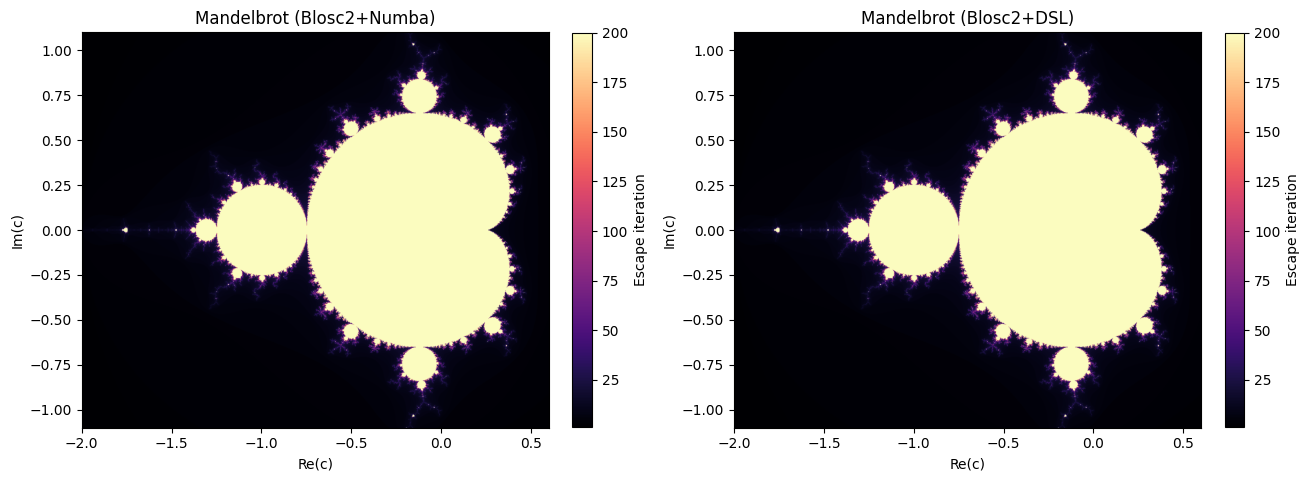

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

im0 = ax[0].imshow(
    img_b2_numba,
    cmap="magma",
    extent=(X_MIN, X_MAX, Y_MIN, Y_MAX),
    origin="lower",
)
ax[0].set_title("Mandelbrot (Blosc2+Numba)")
ax[0].set_xlabel("Re(c)")
ax[0].set_ylabel("Im(c)")
fig.colorbar(im0, ax=ax[0], shrink=0.82, label="Escape iteration")

im1 = ax[1].imshow(
    img_dsl,
    cmap="magma",
    extent=(X_MIN, X_MAX, Y_MIN, Y_MAX),
    origin="lower",
)
ax[1].set_title("Mandelbrot (Blosc2+DSL)")
ax[1].set_xlabel("Re(c)")
ax[1].set_ylabel("Im(c)")
fig.colorbar(im1, ax=ax[1], shrink=0.82, label="Escape iteration")

plt.show()

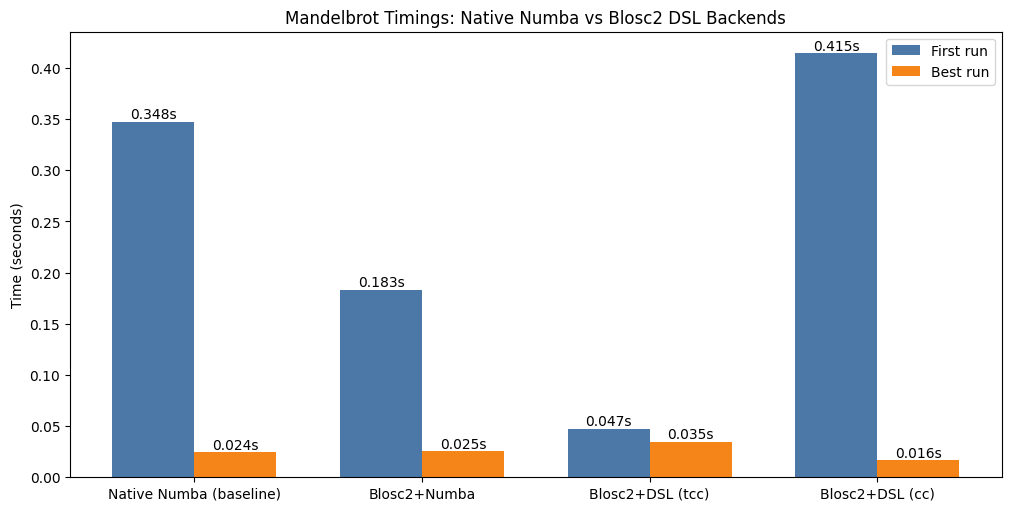

In [7]:
labels = ["Native Numba (baseline)", "Blosc2+Numba", "Blosc2+DSL (tcc)", "Blosc2+DSL (cc)"]
first_times = [t_numba_native_first, t_b2_numba_first, t_dsl_tcc_first, t_dsl_cc_first]
best_times = [t_numba_native, t_b2_numba, t_dsl_tcc, t_dsl_cc]

x = np.arange(len(labels))
width = 0.36

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.bar(x - width / 2, first_times, width, label="First run", color="#4C78A8")
ax.bar(x + width / 2, best_times, width, label="Best run", color="#F58518")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Time (seconds)")
ax.set_title("Mandelbrot Timings: Native Numba vs Blosc2 DSL Backends")
ax.legend()

for i, t in enumerate(first_times):
    ax.text(i - width / 2, t, f"{t:.3f}s", ha="center", va="bottom")
for i, t in enumerate(best_times):
    ax.text(i + width / 2, t, f"{t:.3f}s", ha="center", va="bottom")

plt.show()